# Chapter 10: Text Analytics

## 10.2 Sentiment Classification

### 10.2.1 Loading the dataset

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

train_ds = pd.read_csv( "sentiment_train", delimiter="\t" )
train_ds.head( 5 )

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimately di...


In [2]:
pd.set_option('max_colwidth', 800)
train_ds[train_ds.sentiment == 1][0:5]

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,"this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this."
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimately didn't seem to hold it's own.


In [3]:
train_ds[train_ds.sentiment == 0][0:5]

,sentiment,text
3943,0,da vinci code was a terrible movie.
3944,0,"Then again, the Da Vinci code is super shitty movie, and it made like 700 million."
3945,0,"The Da Vinci Code comes out tomorrow, which sucks."
3946,0,i thought the da vinci code movie was really boring.
3947,0,"God, Yahoo Games has this truly-awful looking Da Vinci Code-themed skin on it's chessboard right now."


### 10.2.2 Exploring the dataset

In [4]:
train_ds.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6918 entries, 0 to 6917
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  6918 non-null   int64 
 1   text       6918 non-null   object
dtypes: int64(1), object(1)
memory usage: 108.2+ KB


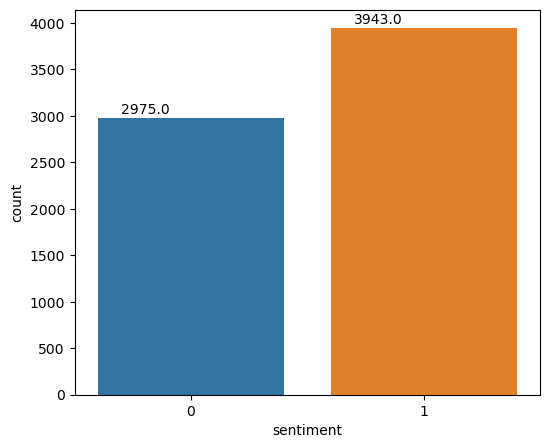

In [5]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure( figsize=(6,5))
# create count plot 
ax = sn.countplot(x='sentiment', data=train_ds)
# annotate
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()+50))

### 10.2.3 Text Preprocessing

#### 10.2.3.2 Creating Count Vectors for *sentiment_train* dataset

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
count_vectorizer = CountVectorizer() 
# Create the dictionary from the corpus
feature_vector = count_vectorizer.fit( train_ds.text )
# Get the feature names
features = list(feature_vector.get_feature_names_out())
print( "Total number of features: ", len(features))

Total number of features:  2132


In [7]:
import random

random.sample(features, 10)

['came',
 'travel',
 'theological',
 'education',
 'meat',
 'working',
 'screwed',
 'husband',
 'formed',
 'dash']

In [8]:
train_ds_features = count_vectorizer.transform( train_ds.text )
type(train_ds_features)

scipy.sparse._csr.csr_matrix

In [9]:
train_ds_features.shape

(6918, 2132)

In [10]:
train_ds_features.getnnz()

65398

In [11]:
print( "Density of the matrix: ",
      train_ds_features.getnnz() * 100 / 
      (train_ds_features.shape[0] * train_ds_features.shape[1]))

Density of the matrix:  0.4434010415225908


#### 10.2.3.3  Displaying Document Vectors

In [12]:
# Converting the matrix to a dataframe
train_ds_df = pd.DataFrame(train_ds_features.todense())
# Setting the column names to the features i.e. words
train_ds_df.columns = features

In [13]:
train_ds[0:1]

,sentiment,text
0,1,The Da Vinci Code book is just awesome.


In [14]:
train_ds_df.iloc[0:1, 150:157]

,away,awesome,awesomely,awesomeness,awesomest,awful,awkward
0,0,1,0,0,0,0,0


In [15]:
train_ds_df[['the', 'da', "vinci", "code", "book", 'is', 'just', 'awesome']][0:1]

,the,da,vinci,code,book,is,just,awesome
0,1,1,1,1,1,1,1,1


#### 10.2.3.4 Removing low frequency words

In [16]:
# summing up the occurrences of features column wise
features_counts = np.sum( train_ds_features.toarray(), axis = 0 )
feature_counts_df = pd.DataFrame( dict( features = features, 
                                    counts = features_counts ) )

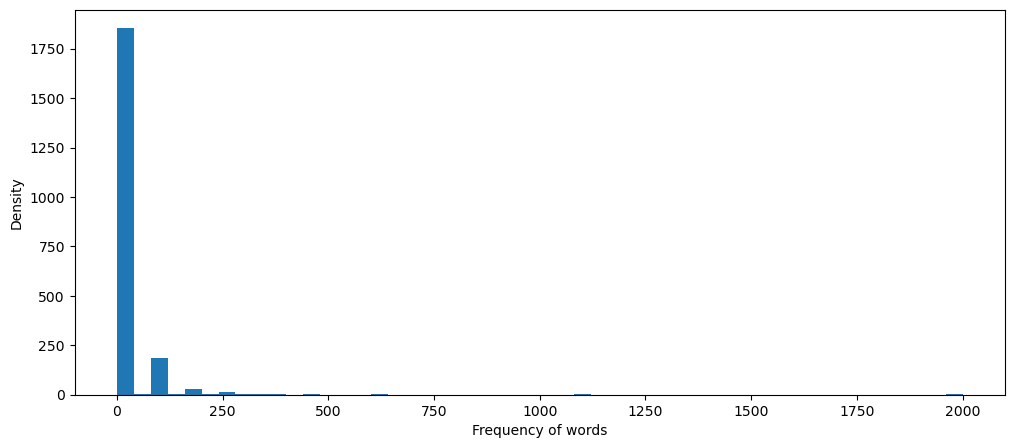

In [17]:
plt.figure( figsize=(12,5))
plt.hist(feature_counts_df.counts, bins=50, range = (0, 2000));
plt.xlabel( 'Frequency of words' )
plt.ylabel( 'Density' );

In [18]:
len(feature_counts_df[feature_counts_df.counts == 1])

1228

In [19]:
# Initialize the CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000) 
# Create the dictionary from the corpus
feature_vector = count_vectorizer.fit( train_ds.text )
# Get the feature names
features = list(feature_vector.get_feature_names_out())
# Transform the document into vectors
train_ds_features = count_vectorizer.transform( train_ds.text )
# Count the frequency of the features
features_counts = np.sum( train_ds_features.toarray(), axis = 0 )
feature_counts = pd.DataFrame( dict( features = features, 
                                    counts = features_counts ) )

In [20]:
feature_counts.sort_values('counts', 
                           ascending = False)[0:15]

,features,counts
866,the,3306
37,and,2154
358,harry,2093
675,potter,2093
138,code,2002
934,vinci,2001
178,da,2001
528,mountain,2000
104,brokeback,2000
488,love,1624


#### 10.2.3.5 Removing Stop Words

In [21]:
from sklearn.feature_extraction import text

my_stop_words = text.ENGLISH_STOP_WORDS

#Printing first few stop words
print("Few stop words: ", list(my_stop_words)[0:10])

Few stop words:  ['go', 'without', 'along', 'due', 'this', 'hasnt', 'sometime', 'serious', 'move', 'here']


In [22]:
# Adding custom words to the list of stop words
my_stop_words = list(text.ENGLISH_STOP_WORDS.union( ['harry', 'potter', 'code', 'vinci', 'da', 
                                                'harry', 'mountain', 'movie', 'movies']))

#### 10.2.3.6 Creating Count Vectors

In [23]:
# Setting stop words list 
count_vectorizer = CountVectorizer( stop_words = my_stop_words, 
                                   max_features = 1000 ) 
feature_vector = count_vectorizer.fit( train_ds.text )
train_ds_features = count_vectorizer.transform( train_ds.text )
features = list(feature_vector.get_feature_names_out())
features_counts = np.sum( train_ds_features.toarray(), axis = 0 )
feature_counts = pd.DataFrame( dict( features = features, 
                                    counts = features_counts ) )

In [24]:
feature_counts.sort_values( "counts", ascending = False )[0:15]

,features,counts
73,brokeback,2000
408,love,1624
39,awesome,1127
436,mission,1094
341,impossible,1093
390,like,974
745,sucks,602
743,sucked,600
297,hate,578
652,really,374


In [25]:
from nltk.stem.snowball import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

#Custom function for stemming and stop word removal

def stemmed_words(doc):
    ### Stemming of words
    stemmed_words = (stemmer.stem(w) for w in analyzer(doc))
    ### Remove the words in stop words list
    non_stop_words = [ word for word in list(set(stemmed_words) - set(my_stop_words)) ]
    return non_stop_words

In [26]:
count_vectorizer = CountVectorizer( analyzer=stemmed_words, 
                                   max_features = 1000) 
feature_vector = count_vectorizer.fit( train_ds.text )
train_ds_features = count_vectorizer.transform( train_ds.text )
features = list(feature_vector.get_feature_names_out())
features_counts = np.sum( train_ds_features.toarray(), axis = 0 )
feature_counts = pd.DataFrame( dict( features = features, 
                                    counts = features_counts ) )
feature_counts.sort_values( "counts", ascending = False )[0:15]

,features,counts
80,brokeback,1930
297,harri,1916
407,love,1837
797,suck,1378
922,wa,1142
43,awesom,1116
345,imposs,1090
433,mission,1090
439,movi,1052
393,like,823


#### 10.2.3.7 Distribution of words across different sentiment

In [27]:
# Convert the document vector matrix into dataframe
train_ds_df = pd.DataFrame(train_ds_features.todense())
# Assign the features names to the column
train_ds_df.columns = features
# Assign the sentiment labels to the train_ds
train_ds_df['sentiment'] = train_ds.sentiment

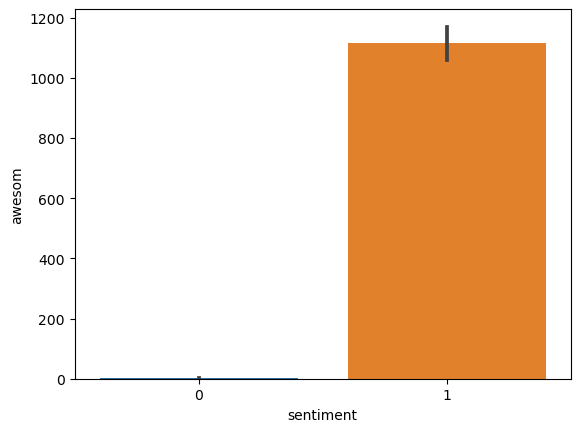

In [28]:
sn.barplot( x = 'sentiment', y = 'awesom', data = train_ds_df, estimator=sum );

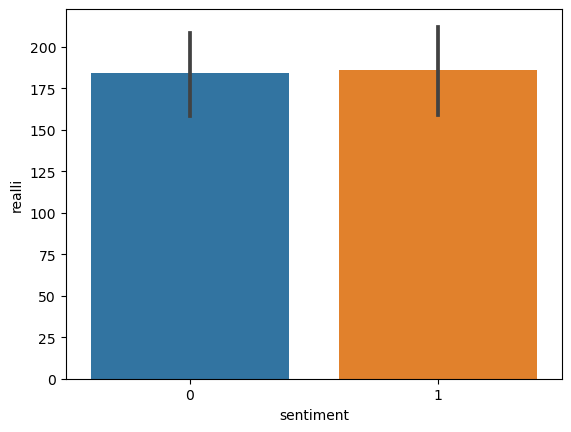

In [29]:
sn.barplot( x = 'sentiment', y = 'realli', data = train_ds_df, estimator=sum );

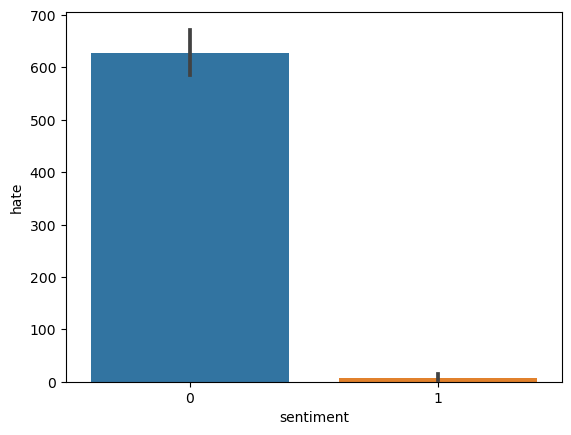

In [30]:
sn.barplot( x = 'sentiment', y = 'hate', data = train_ds_df, estimator=sum );

### 10.3 Naive Bayes Model for Sentiment Classification

#### 10.3.1 Split the dataset

In [31]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split( train_ds_features, 
                                                    train_ds.sentiment, 
                                                    test_size = 0.3, 
                                                    random_state = 42 )

#### 10.3.2 Build Naive Bayes Model

In [32]:
from sklearn.naive_bayes import BernoulliNB 

nb_clf = BernoulliNB()
nb_clf.fit( train_X.toarray(), train_y )

BernoulliNB()

#### 10.3.3 Make prediction on test case

In [33]:
test_ds_predicted = nb_clf.predict( test_X.toarray() )

#### 10.3.4 Print clasification report

In [34]:
from sklearn import metrics

print( metrics.classification_report( test_y, test_ds_predicted ) )

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       873
           1       0.98      0.99      0.98      1203

    accuracy                           0.98      2076
   macro avg       0.98      0.98      0.98      2076
weighted avg       0.98      0.98      0.98      2076



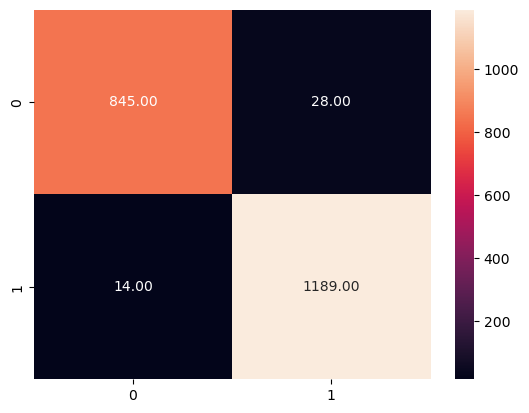

In [35]:
from sklearn import metrics

cm = metrics.confusion_matrix( test_y, test_ds_predicted )
sn.heatmap(cm, annot=True,  fmt='.2f' );

### 10.4 Using TF-IDF Vectorizer

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer( analyzer=stemmed_words, 
                                   max_features = 1000) 
feature_vector = tfidf_vectorizer.fit( train_ds.text )
train_ds_features = tfidf_vectorizer.transform( train_ds.text )
features = list(feature_vector.get_feature_names_out())

In [37]:
from sklearn.naive_bayes import GaussianNB 

train_X, test_X, train_y, test_y = train_test_split( train_ds_features, 
                                                    train_ds.sentiment, 
                                                    test_size = 0.3, 
                                                    random_state = 42 )

nb_clf = GaussianNB()
nb_clf.fit( train_X.toarray(), train_y )

GaussianNB()

In [38]:
test_ds_predicted = nb_clf.predict( test_X.toarray() )
print( metrics.classification_report( test_y, test_ds_predicted ) )

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       873
           1       0.97      0.97      0.97      1203

    accuracy                           0.97      2076
   macro avg       0.97      0.97      0.97      2076
weighted avg       0.97      0.97      0.97      2076



### 10.5.1 Using N-grams

In [39]:
import nltk
from nltk.stem import PorterStemmer
# library for regular expressions
import re

stemmer = PorterStemmer()

def get_stemmed_tokens( doc ):
    # Tokenize the documents to words
    all_tokens = [word for word in nltk.word_tokenize(doc)]
    clean_tokens = []
    # remove the all characters other than alphabets. It takes a regex for matching.
    for each_token in all_tokens:
        if re.search('[a-zA-Z]', each_token):
            clean_tokens.append(each_token)
    # Stem the words
    stemmed_tokens = [stemmer.stem(t) for t in clean_tokens]
    return stemmed_tokens

In [40]:
tfidf_vectorizer = TfidfVectorizer(max_features=500,
                                   stop_words='english',
                                   tokenizer=get_stemmed_tokens, 
                                   ngram_range=(1,2))

feature_vector = tfidf_vectorizer.fit( train_ds.text )
train_ds_features = tfidf_vectorizer.transform( train_ds.text )
features = list(feature_vector.get_feature_names_out())

### 10.5.2 Build the model using *n-grams*

In [41]:
train_X, test_X, train_y, test_y = train_test_split( train_ds_features, 
                                                    train_ds.sentiment, 
                                                    test_size = 0.3, 
                                                    random_state = 42 )

nb_clf = BernoulliNB()
nb_clf.fit( train_X.toarray(), train_y )
test_ds_predicted = nb_clf.predict( test_X.toarray() )
print( metrics.classification_report( test_y, test_ds_predicted ) )

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       873
           1       0.96      1.00      0.98      1203

    accuracy                           0.97      2076
   macro avg       0.98      0.97      0.97      2076
weighted avg       0.97      0.97      0.97      2076



### 10.5.2 Build a Random Forest Model to find important words

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Adding custom words to the list of stop words
my_stop_words = list(text.ENGLISH_STOP_WORDS.union( ['harry', 'potter', 'code', 'vinci', 'da', 
                                                     'harry', 'mountain', 'movie', 'movies', 'impossible', 
                                                     'mission', 'mountain', 'brokeback']))

# Create the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500,
                                   stop_words=my_stop_words)

feature_vector = tfidf_vectorizer.fit( train_ds.text )
train_ds_features = tfidf_vectorizer.transform( train_ds.text )
features = list(feature_vector.get_feature_names_out())

# Split the dataset into train and test sets
train_X, test_X, train_y, test_y = train_test_split( train_ds_features, 
                                                    train_ds.sentiment, 
                                                    test_size = 0.3, 
                                                    random_state = 42 )
# Build Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators = 200, 
                                max_depth = 10, 
                                random_state = 42)
rf_clf.fit( train_X.toarray(), train_y )

# Predict on test set and print the classification report
test_ds_predicted = rf_clf.predict( test_X.toarray() )
print( metrics.classification_report( test_y, test_ds_predicted ) )

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       873
           1       0.95      1.00      0.97      1203

    accuracy                           0.97      2076
   macro avg       0.97      0.96      0.97      2076
weighted avg       0.97      0.97      0.97      2076



In [43]:
important_words = pd.DataFrame({ "words": features,
                                 "importance": rf_clf.feature_importances_} )
important_words.sort_values("importance", ascending = False)[0:10]

,words,importance
285,love,0.125478
20,awesome,0.102528
422,sucked,0.082199
210,hate,0.078392
424,sucks,0.067625
421,suck,0.039398
420,stupid,0.038761
270,like,0.034307
251,just,0.026007
326,oh,0.023434
